<a href="https://colab.research.google.com/github/ShoSato-047/STAT380/blob/main/STAT380_3_1_(2025)_Towards_a_GLM_intro_to_likelihoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motivation

For simple ordinary linear regression of the form $Y = \beta_0 + \beta_1 X$, the coefficients $\beta_0$ and $\beta_1$ are chosen to minimize the sum-of-squared residuals, among all possible lines:

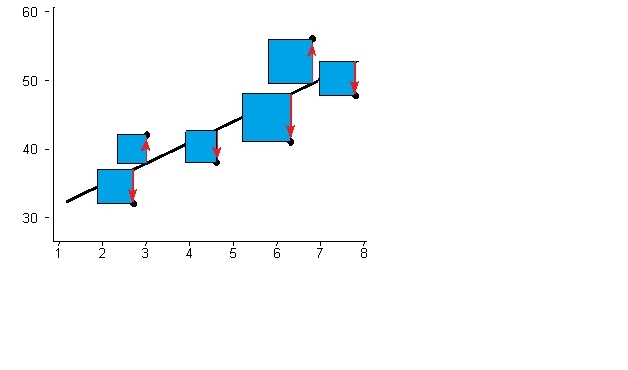

Thus, $\hat\beta_0$ and $\hat\beta_1$ are often called *least-squares estimates*.  For more general linear models with potentially non-continuous outcomes, we the parameters are estimated via *maximum likelihood*.  In the next couple notebooks we will define likelihoods, how they are used to estimate parameters, and how likelihoods are used to compare models.

# Case study: Twins data


Consider data from the Minnesota Twins 2022 season, which I scraped from [boxscores on the Fangraphs website](https://www.fangraphs.com/boxscore.aspx?date=2022-04-15&team=Twins&dh=0&season=2022)

In [1]:
twins <- read.csv('https://www.dropbox.com/s/6cl8crdkyk1ptbt/twins22.csv?dl=1')
head(twins)

,date,month,opponent,win,home.away,score,twins.HR,opponent.HR
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>
1,2022-04-08,Apr,Mariners,0,home,1-2,1,1
2,2022-04-09,Apr,Mariners,0,home,3-4,2,1
3,2022-04-10,Apr,Mariners,1,home,10-4,6,1
4,2022-04-11,Apr,Mariners,1,home,4-0,0,0
5,2022-04-12,Apr,Dodgers,0,home,2-7,0,0
6,2022-04-13,Apr,Dodgers,0,home,0-7,0,4


## Modeling number of home runs

We'll begin by modeling $Y$, the number of home runs hit by the Twins per game.





<img src="https://img.mlbstatic.com/mlb-images/image/private/ar_16:9,g_auto,q_auto:good,w_1024,c_fill,f_jpg/mlb/bwfi3u2xpq6rhjmrhwm6" width=40%>

[image source](https://img.mlbstatic.com/mlb-images/image/private/ar_16:9,g_auto,q_auto:good,w_1024,c_fill,f_jpg/mlb/bwfi3u2xpq6rhjmrhwm6)


Before getting into details let's explore the distribution of $Y$, by finding the number of games where $k$ home runs are hit and graphing the corresponding results:

In [2]:
library(dplyr)
(twins
  %>% group_by(twins.HR)
  %>% summarize(ngames = n())
  %>% mutate(pct.games = round(ngames/162,3))
)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




twins.HR,ngames,pct.games
<int>,<int>,<dbl>
0,58,0.358
1,60,0.370
2,25,0.154
3,13,0.080
4,2,0.012
5,3,0.019
6,1,0.006


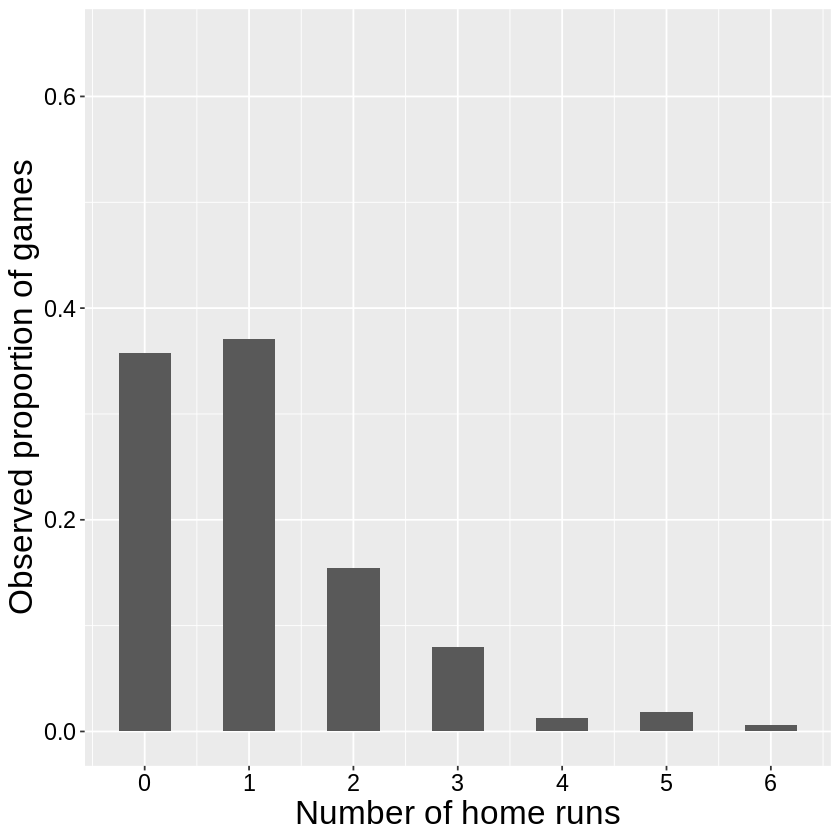

In [3]:
library(ggplot2)
ggplot(data = twins) +
  geom_bar(aes(x = twins.HR, y = after_stat(count)/162),width = .5) +
    xlab('Number of home runs') + ylab('Observed proportion of games') +
      theme(axis.text = element_text(size = 14,color='black')) +
      theme(axis.title = element_text(size = 20,color='black')) +
      scale_x_continuous(breaks = 0:6) +
        ylim(c(0,0.65))

Since $Y$ measures the number of occurrences per unit time (one game), a Poisson model seems reasonable for $Y$.  Since a single time unit is one game, and $Y$ is measured over $t=1$ game, we can say $Y\sim POI(\lambda\cdot 1)$ where $\lambda$ represents the underlying rate of home runs per game.  Or more simply, $Y\sim POI(\lambda)$.

**Our goal: estimate $\lambda$.**

# The peck-and-check approach

The big idea here is to find a $\lambda$ that results in a Poisson model that fits the above observed proportions well.

Let's blindly guess at two values of $\lambda$:  

* Model 1: $\lambda = 0.5$ (interpreted: the Twins hit, on average, 0.5 HR/game or 1 HR every 2 games)
* Model 2: $\lambda = 2$ (interpreted: the Twins hit, on average, 2 HR/game)

Evaluating these models involves finding finding $P(Y=k)$, for each $\lambda$, i.e. evaluating:

$$P(Y=k) = \frac{e^{-\lambda}\lambda^k}{k!},  k\in \{0,1,2,3,4,5,6\}$$

We would then compare these probabilities to the observed proportions in our data.

## Fitting Model 1

Fitting Model 1 with $\lambda = 0.5$ simply means finding $P(Y=k)$ for $\lambda = 0.5$, i.e. evaluating:

$$P(Y=k) = \frac{e^{-0.5}0.5^k}{k!},  k\in \{0,1,2,3,4,5,6\}$$

In [4]:
(model1.probs <- round(dpois(0:6, 0.5),4))

[1] 0.6065 0.3033 0.0758 0.0126 0.0016 0.0002 0.0000

Graphing these:

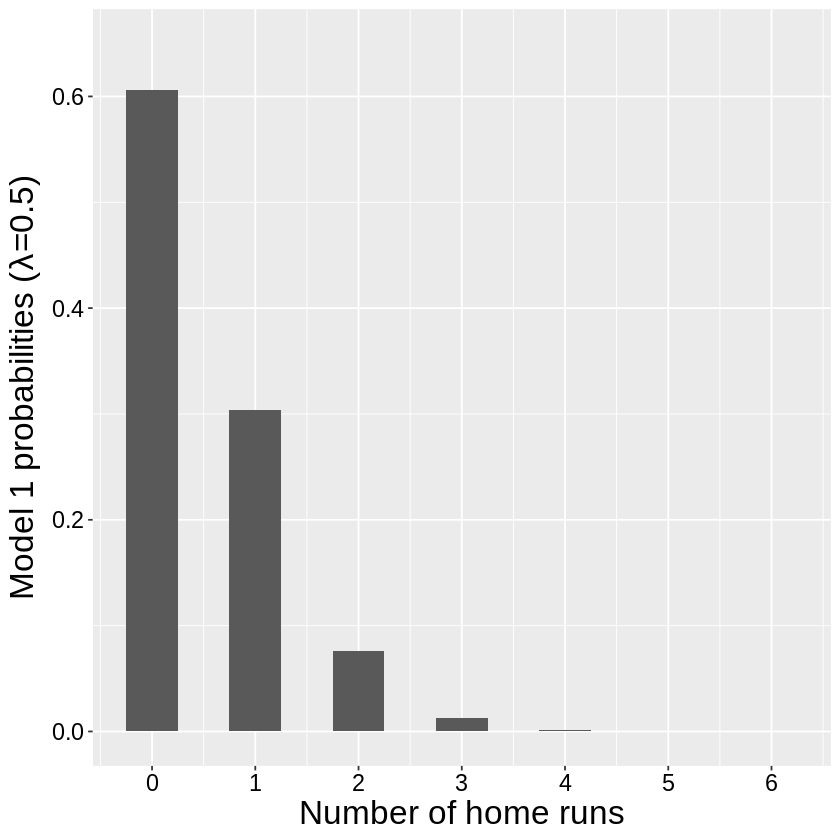

In [6]:
ggplot() +
  geom_bar(aes(x = 0:6, y = model1.probs),stat='identity',width = .5) +
    xlab('Number of home runs') + ylab(expression(paste('Model 1 probabilities (',lambda,'=0.5)'))) +
      theme(axis.text = element_text(size = 14,color='black')) +
      theme(axis.title = element_text(size = 20,color='black')) +
      scale_x_continuous(breaks = 0:6)+
        ylim(c(0,0.65))

Not bad, but this model appears to far over-weight $Y=0$ observations and not give enough weight to $Y=1$ or above.  Maybe our Model 2 $\lambda$ will be better.

## Fitting Model 2


The process is exactly the same, except we will plug in $\lambda = 2$ into the Poisson formula instead.  The Model 2 probabilities are:

$$P(Y=k) = \frac{e^{-2}2^k}{k!},  k\in \{0,1,2,3,4,5,6\}$$

In [7]:
(model2.probs <- round(dpois(0:6, 2),4))

[1] 0.1353 0.2707 0.2707 0.1804 0.0902 0.0361 0.0120

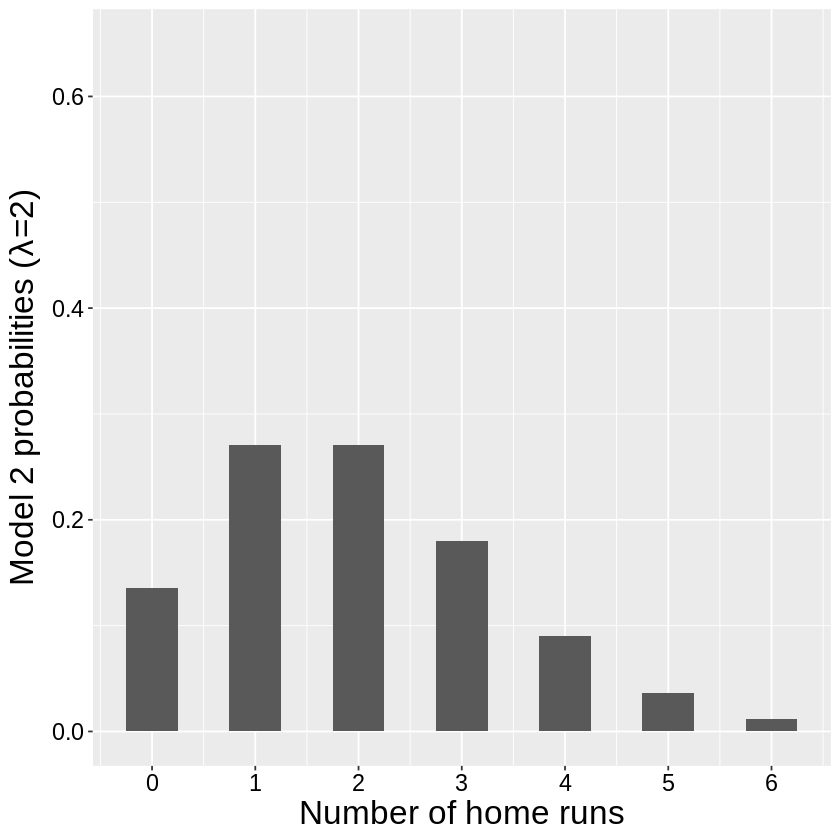

In [8]:
ggplot() +
  geom_bar(aes(x = 0:6, y = model2.probs),stat='identity',width = .5) +
    xlab('Number of home runs') + ylab(expression(paste('Model 2 probabilities (',lambda,'=2)'))) +
      theme(axis.text = element_text(size = 14,color='black')) +
      theme(axis.title = element_text(size = 20,color='black')) +
      scale_x_continuous(breaks = 0:6)+
        ylim(c(0,0.65))

$\lambda = 2$ appears to have drastically over-compensated; it now significantly over-estimates the proportion of 0-HR games and gives too much weight to 2-HR games and above.  

Putting all the graphs next to each other; the observed data on the left and the two fitted models on the right:

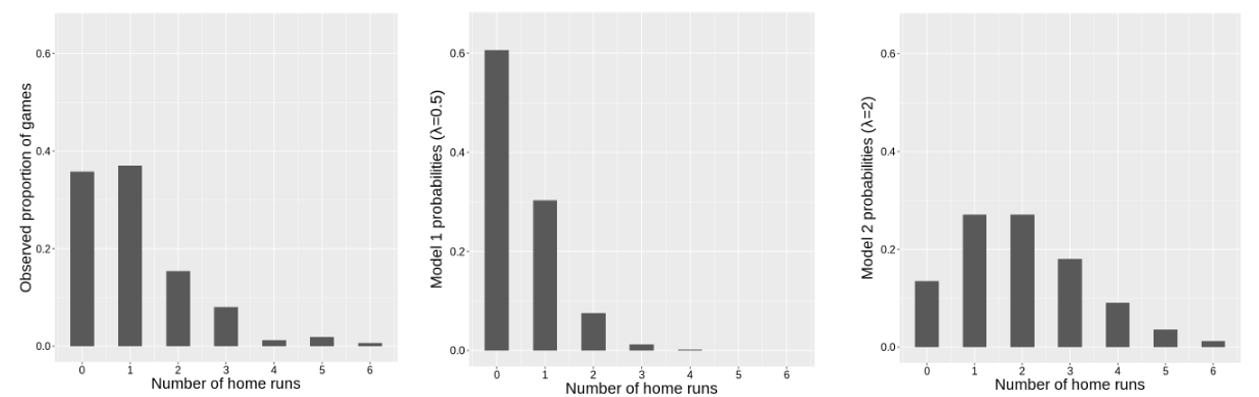

This raises a couple questions:

* Neither Model 1 nor 2 are ideal.  But can we determine which model, 1 or 2, fits better?
* It appears we need a $\lambda$ somewhere between 0.5 and 2.  But where?  There are infinitely many possibilities, and this peck-and-check method is pretty inefficient.  Can we find an "optimal" value of $\lambda$?

# The model likelihood


Given $n$ discrete observations $Y_1$, $Y_2$,...,$Y_n$, with a probability model that depends on a parameter $\theta$ (possibly a vector), the ***likelihood of $\theta$*** is defined to be:

$$Lik(\theta) = P(Y_1 = k_1)P(Y_2 = k_2)⋯P(Y_n = k_n) = \prod_{i=1}^n P(Y_i = k_i)$$

Here, $k_1$ is just the observed value of $Y_1$; $k_2$ is the first observation of $Y_2$, etc.  

It's called a ***likelihood*** because it represents, overall, how ***likely*** the entire $n$ observed data points are given the value of the parameter $\theta$.


Reconsider our data:

In [ ]:
head(twins,3)

,date,month,opponent,win,home.away,score,twins.HR,opponent.HR
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>
1,2022-04-08,Apr,Mariners,0,home,1-2,1,1
2,2022-04-09,Apr,Mariners,0,home,3-4,2,1
3,2022-04-10,Apr,Mariners,1,home,10-4,6,1


In [ ]:
tail(twins,3)

,date,month,opponent,win,home.away,score,twins.HR,opponent.HR
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>
160,2022-10-03,Oct,White Sox,0,away,2-3,1,1
161,2022-10-04,Oct,White Sox,0,away,3-8,1,1
162,2022-10-05,Oct,White Sox,1,away,10-1,2,0


We have $n=162$ and $k_1 = 1$, $k_2=2$, $k_3 = 6$, etc.

For our example, $P(Y_i=k_i)$ is defined by the Poisson model, and the parameter $\theta$ is just $\lambda$.  

Thus:

$$Lik(\lambda) = P(Y_1 = 1)\times P(Y_2 = 2)\times P(Y_3 = 6)\times ...  \times P(Y_{162}=2)$$
$$ = \frac{e^{-\lambda}\lambda^1}{1!}\times\frac{e^{-\lambda}\lambda^2}{2!} \times\frac{e^{-\lambda}\lambda^6}{6!} \times ... \times \frac{e^{-\lambda}\lambda^2}{2!}$$

In [11]:
# plug in lambda = 0.5 and 2 into the above equation

## Evaluating the likelihood: peck-and-check $\lambda$s

Let's find the likelihood for our first peck-and-check value of $\lambda = 0.5$ from Model 1, above.

In [9]:
# dopis = probability of lambda = 0.5
# prob = likelihood
(Likelihood.model1 <- prod(dpois(twins$twins.HR, 0.5)))

[1] 5.518142e-119

Whew, that's tiny! 0.0000000(118 times)5518. How does it compare to the Model 2 $\lambda = 2$?

In [12]:
(Likelihood.model2 <- prod(dpois(twins$twins.HR, 2)))

[1] 2.370894e-117

**This likelihood is higher (two fewer 0s), thus $\lambda = 2$ fits these data better (makes the observed data values more likely) than $\lambda = 0.5$.**

# Log-likelihood

Notice the two likelihood values evaluated for $\lambda = 0.5$ and $\lambda = 2$ are extremely small.  This is common in practice.  To make model comparisons easier and likelihood maximization more stable, we typically work with ***log-likelihoods***.  The ***log-likelihood of a parameter $\theta$*** is defined to be:

$$logLik(\theta) = \log(Lik(\theta)) = \log\left(P(Y_1 = k_1)P(Y_2 = k_2)⋯P(Y_n = k_n)\right)$$
$$=\log(P(Y_1 = k_1)) + \log(P(Y_2 = k_2)) + ... + \log(P(Y_n = k_n))$$
$$=\sum_{i=1}^n \log(P(Y_i = k_i))$$

Note that, due to properties of logarithms, the log of the product is the sum of the logs.  

In practice, the natural log (log-base-e) is used.


An important quality of the log function is that it's one-to-one.  This implies if, if Model A has a higher likelihood than Model B, then the log-likelihood of Model A will also be higher than the log-likelihood of Model B.  Thus it suffices to compare log-likelihoods instead of likelihoods, and these comparisons are typically more numerically stable (don't involve comparing such tiny numbers).

For our example, the log-likelihood is:

$$logLik(\lambda) = \log\left(\frac{e^{-\lambda}\lambda^1}{1!}\right)  + \log\left(\frac{e^{-\lambda}\lambda^2}{2!}\right) + \log\left(\frac{e^{-\lambda}\lambda^6}{6!}\right) + ... + \log\left(\frac{e^{-\lambda}\lambda^0}{0!}\right)+\log\left(\frac{e^{-\lambda}\lambda^2}{2!}\right)$$

### Log-likelihood: peck-and-check $\lambda$s

Let's find and compare the log-likelihoods for our two $\lambda$ values we considered earlier.

First, for Model 1 ($\lambda = 0.5$):

In [14]:
#Finding the log of the product, model 1 (lambda = 0.5):
(logLik.model1 <- log(Likelihood.model1))

[1] -272.2996

In [15]:
#Same thing, but using the sum of the logged probabilities:
# get probability in log first, then sum
sum(log(dpois(twins$twins.HR, lambda = 0.5)))

[1] -272.2996

And now for Model 2

In [16]:
#Log-likelihood, model 2 (lambda = 2):
(logLik.model2 <- log(Likelihood.model2))

[1] -268.5392

Once again, we see that Model 2 ($\lambda = 2$) fits the home run data better (has a higher log-likelihood).  That is:

$$logLik(2) > logLik(0.5).$$

This comparison is also much easier to make (as long as we keep the negative signs straight), not requiring us to compare tiny, tiny values.  

## Maximizing the log-likelihood


We've used the log-likelihood to determine which of our two peck-and-check $\lambda$s are "best".  But is there a better one?  To answer this, let's plot the log-likelihood for a sequence of possible $\lambda$s. To accomplish this we need to write a function that returns $logLik(\lambda)$ for any inputed value of $\lambda$.

In [17]:
#Writing the log-likelihood function:
loglik.hr <- function(lambda) {
  out <- sum(log(dpois(twins$twins.HR, lambda)))
  return(out)
}

In [18]:
#Checking it works for two lambdas we already know:
loglik.hr(0.5)

[1] -272.2996

In [19]:
loglik.hr(2)

[1] -268.5392

In [20]:
#Generating a sequence of lambdas:
lambda.sequence <- seq(0.01, 2.5, l=100)

In [21]:
#Evaluating the log-likelihood for each lambda in the sequence:
# sapply = something similar to lambda function in python
loglik.sequence <- sapply(lambda.sequence,loglik.hr)

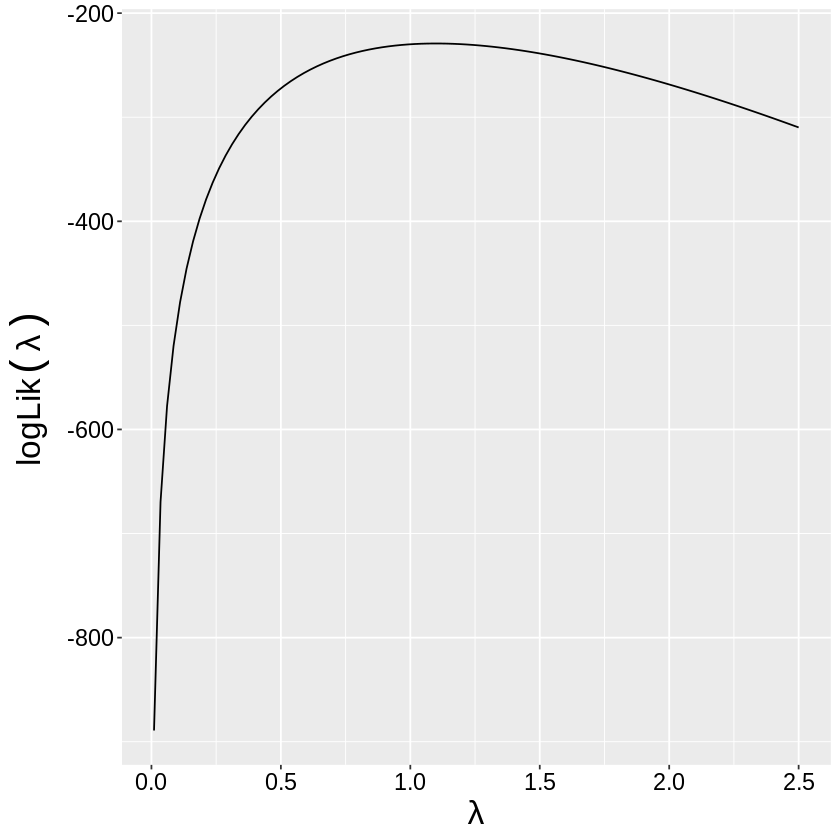

In [22]:
#Plotting:
ggplot() +
  geom_line(aes(x = lambda.sequence, y = loglik.sequence))+
    xlab(expression(lambda)) + ylab(expression(logLik(lambda))) +
     theme(axis.text = element_text(size = 14,color='black')) +
      theme(axis.title = element_text(size = 20,color='black'))

It looks like the log-likelihood is maximized around $\lambda \approx 1$.  We can find the exact spot the maximum occurs with the `optimize()` function:

In [24]:
# R calculates the max for you
optimize(loglik.hr, interval = c(0, 2.5), maximum = TRUE)

$maximum
[1] 1.098754

$objective
[1] -229.1541

So $1.099$ is the value of $\lambda$ that *maximizes* the *log-likelihood*, and thus the likelihood as well.  The value of the parameter that maximizes the likelihood of seeing the observed data is called the ***maximum likelihood estimate***, or MLE.  We use notation like $\hat\lambda_{MLE}$ to denote these estimates.

### Model evaluated at MLE

Let's find the modeled probabilities using our MLE of $\hat\lambda_{MLE} = 1.099$:

In [25]:
(mle.probs <- round(dpois(0:6, 1.099),4))

[1] 0.3332 0.3662 0.2012 0.0737 0.0203 0.0045 0.0008

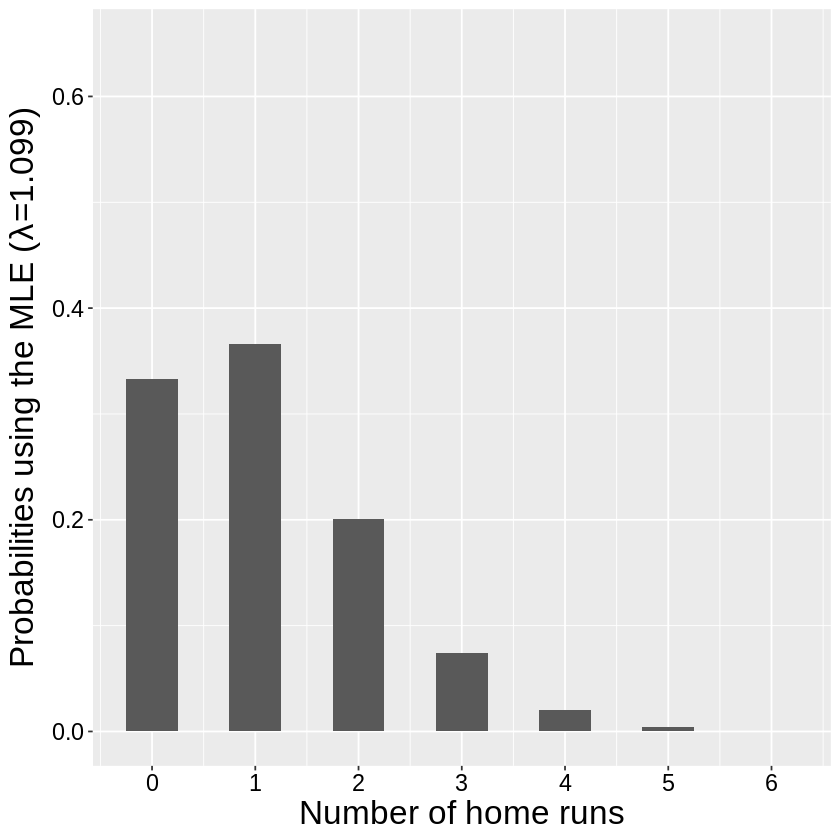

In [26]:
ggplot() +
  geom_bar(aes(x = 0:6, y = mle.probs),stat='identity',width = .5) +
    xlab('Number of home runs') + ylab(expression(paste('Probabilities using the MLE (',lambda,'=1.099)'))) +
      theme(axis.text = element_text(size = 14,color='black')) +
      theme(axis.title = element_text(size = 20,color='black')) +
      scale_x_continuous(breaks = 0:6)+
        ylim(c(0,0.65))

Putting all the models we've considered so far next to each other:

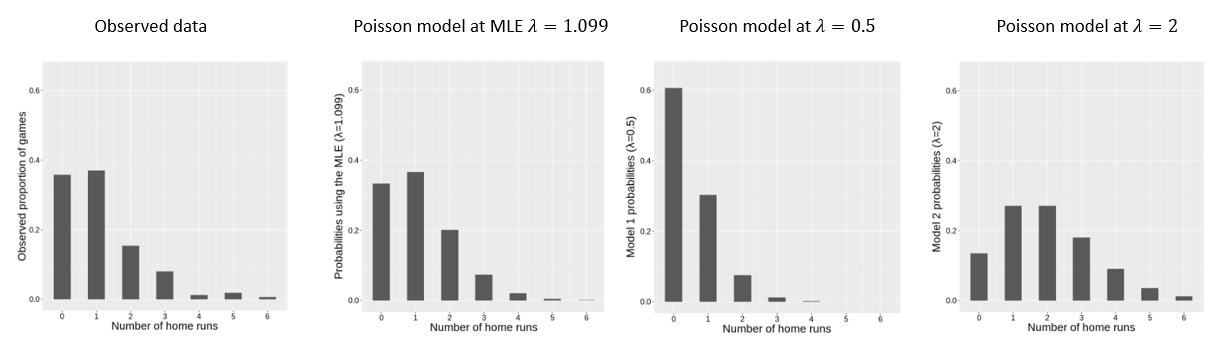

Clearly, the Poisson probabilities using the MLE of $\hat\lambda_{MLE} = 1.099$ best fits the observed probabilities.  

### The MLE isn't mysterious

It turns out that the MLE, $\hat\lambda_{MLE} = 1.099$, has a pretty data-based interpretation.   Recall that $\lambda$ measures the underlying average number of occurrences (home runs) per unit time (game).  We probably should have been able to guess at a pretty good estimate of what this rate is:

In [27]:
# MLE = maximized likelihood estimate

In [28]:
round(mean(twins$twins.HR),4)

[1] 1.0988

To refresh your memory:

In [ ]:
round(optimize(loglik.hr, interval = c(0.5, 2), maximum = TRUE)$maximum,4)

[1] 1.0988

I.e., the MLE of $\lambda = 1.099$ is nothing other than the observed sample mean number of home runs hit per game!  

# New example: Win/Loss

We also could consider modeling whether each game was a win or a loss.  Now, with $Y$ representing whether each game is a win or a loss (i.e., the number of 1's out of $n=1$ trials), we have:

$$Y\sim BIN(1,p)$$

Thus:

$$P(Y_i=k_i) = p^{k_i}(1-p)^{1-k_i}; k_i \in \{0,1\}.$$

This is the same as saying:

$$P(Y_i=1) = p^1 (1-p)^0 = p$$
$$P(Y_i=0) = p^0 (1-p)^1 = (1-p)$$

The log-likelihood function is now a function of $p$, given that $p$ is our parameter:

$$logLik(p) = \sum_{i=1}^n\log(P(Y_i = k_i))$$

Looking at the first several rows:

In [29]:
head(twins, 3)

,date,month,opponent,win,home.away,score,twins.HR,opponent.HR
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>
1,2022-04-08,Apr,Mariners,0,home,1-2,1,1
2,2022-04-09,Apr,Mariners,0,home,3-4,2,1
3,2022-04-10,Apr,Mariners,1,home,10-4,6,1


In [30]:
tail(twins,3)

,date,month,opponent,win,home.away,score,twins.HR,opponent.HR
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>
160,2022-10-03,Oct,White Sox,0,away,2-3,1,1
161,2022-10-04,Oct,White Sox,0,away,3-8,1,1
162,2022-10-05,Oct,White Sox,1,away,10-1,2,0


Thus we would have:

$$logLik(p) = \log(1-p) + \log(1-p) + \log(p) + ... + \log(1-p) + \log(1-p) + \log(p) $$
$$ = (\mbox{# of losses})\log(1-p) + (\mbox{# of wins})\log(p)$$

Let's write the log-likelihood function and find $\hat p_{MLE}$, the value of $p$ that maximizes the likelihood of observing the wins and losses that we did--in other words, the maximum likelihood estimator, or MLE, of $p$.  

In [33]:
#Grabbing the binary win/loss results:
table(twins$win)

# 84 wins/ 78 loses


 0  1 
84 78 

In [34]:
#Alternative approach, mimicking poisson examples
loglik.wins.alternative <- function(p) {
  out <- sum(log(dbinom(twins$win, 1, p)))
  return(out)
}

In [37]:
#Function that returns the log-likelihood of the data for a given p:
loglik.wins <- function(p) {
 out <- 84*log(1-p) + 78*log(p)
 return(out)
}

In [38]:
loglik.wins.alternative(0.5)
loglik.wins(0.5)

[1] -112.2898

[1] -112.2898

In [40]:
#Generating sequence of p's:
p.seq <- seq(.01, .99, l=100)

In [41]:
#Evaluating the log-likelihood at each p in the sequence:
loglik.pseq <- sapply(p.seq, loglik.wins)

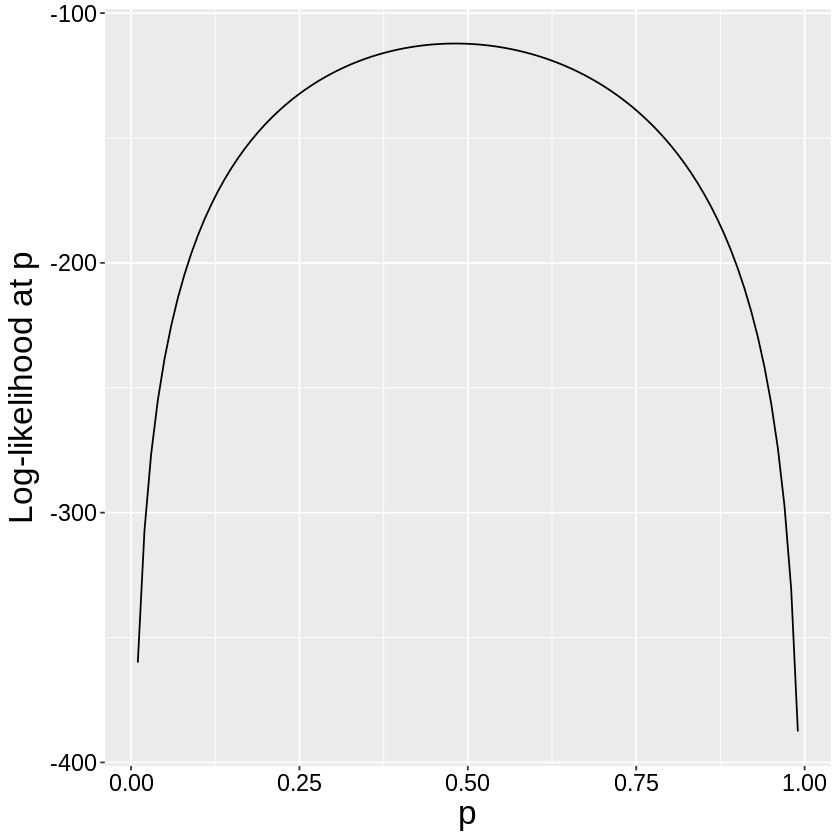

In [42]:
ggplot() +
  geom_line(aes(x = p.seq, y = loglik.pseq))+
    xlab('p') + ylab('Log-likelihood at p') +
      theme(axis.text = element_text(size = 14,color='black')) +
      theme(axis.title = element_text(size = 20,color='black'))

We can find where this function has its maximum using `optimize()`:

In [44]:
optimize(loglik.wins, interval = c(0,1), maximum=TRUE)

$maximum
[1] 0.4814815

$objective
[1] -112.1787

Thus, the MLE is $\hat p_{MLE} = 0.481$.  Once again, this estimate has a perfectly data-based explanation:

In [45]:
table(twins$win)


 0  1 
84 78 

The Twins went 78-84 in 2022, a winning percentage of...you guessed it...78/162, or 0.481:

In [46]:
table(twins$win)/162


        0         1 
0.5185185 0.4814815 

Thus the MLE, the value of $p$ that makes the observed data most likely, is the observed proportion of times the Twins won in 2022!

# Up next

So far we have defined likelihoods for an outcome $Y$ and described how to use maximum likelihood to estimate model parameters.  In the next notebook we extend these ideas to describe how we can use likelihoods to compare models with different $X$ terms.